# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://learn.wbscodingschool.com/courses/data-science/lessons/%f0%9f%93%9d-5-data-quality/) and use what you've learnt to see how reliable the data is.

In [2]:
import pandas as pd

Load our cleaned DataFrames

In [3]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

## 2.&nbsp; Exclude unwanted orders

In [5]:
orders = orders_cl.copy()
orders.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

In [6]:
orders = orders.query('state == "Completed"')
len(orders)

46605

In [7]:
orderlines = orderlines_cl.copy()
orderlines.id_order.isin(orders.order_id).value_counts()

False    159536
True      56714
Name: id_order, dtype: int64

In [8]:
orderlines = orderlines[orderlines.id_order.isin(orders.order_id)]
len(orderlines)

56714

In [9]:
orders.order_id.isin(orderlines.id_order).value_counts()

True     43064
False     3541
Name: order_id, dtype: int64

In [10]:
orders = orders[orders.order_id.isin(orderlines.id_order)]
len(orders)

43064

## 3.&nbsp; Exclude orders with unknown products


In [11]:
orderlines.sku.isin(products_cl.sku).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

In [12]:
orders.order_id.isin(orderlines[~orderlines.sku.isin(products_cl.sku)].id_order).value_counts()

False    41701
True      1363
Name: order_id, dtype: int64

In [13]:
orders = orders[~orders.order_id.isin(orderlines[~orderlines.sku.isin(products_cl.sku)].id_order)]
len(orders)

41701

In [14]:
orderlines.id_order.isin(orders.order_id).value_counts()

True     54324
False     2390
Name: id_order, dtype: int64

In [15]:
orderlines = orderlines[orderlines.id_order.isin(orders.order_id)]
len(orderlines)

54324

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
(
    orderlines
    .assign(unit_price_total = orderlines.unit_price * orderlines.product_quantity)
)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,142.49
...,...,...,...,...,...,...,...,...
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [ ]:
(
    orderlines
    .assign(unit_price_total = orderlines.unit_price * orderlines.product_quantity)
    .groupby('id_order')
    [['unit_price_total']]
    .sum()
)

,unit_price_total
id_order,
241423,129.16
242832,10.77
243330,77.99
245275,149.00
245595,105.98
...,...
527042,13.99
527070,19.98
527074,19.98


### What is the average difference between `total_paid` and `unit_price_total`?

In [ ]:
orders = (
    orders
    .join(
        on='order_id',
        other=(
            orderlines
            .assign(unit_price_total = orderlines.unit_price * orderlines.product_quantity)
            .groupby('id_order')
            [['unit_price_total']]
            .sum()
        )
    )
    .assign(diff = lambda x: round(x.total_paid - x.unit_price_total, 2))
)
orders

,order_id,created_date,total_paid,state,unit_price_total,diff
1,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
2,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
3,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
5,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
6,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
...,...,...,...,...,...,...
226544,527042,2018-03-14 11:47:50,18.98,Completed,13.99,4.99
226572,527070,2018-03-14 11:50:48,24.97,Completed,19.98,4.99
226576,527074,2018-03-14 11:51:42,24.97,Completed,19.98,4.99
226598,527096,2018-03-14 11:58:40,34.96,Completed,29.97,4.99


### What is the distribution of these differences?

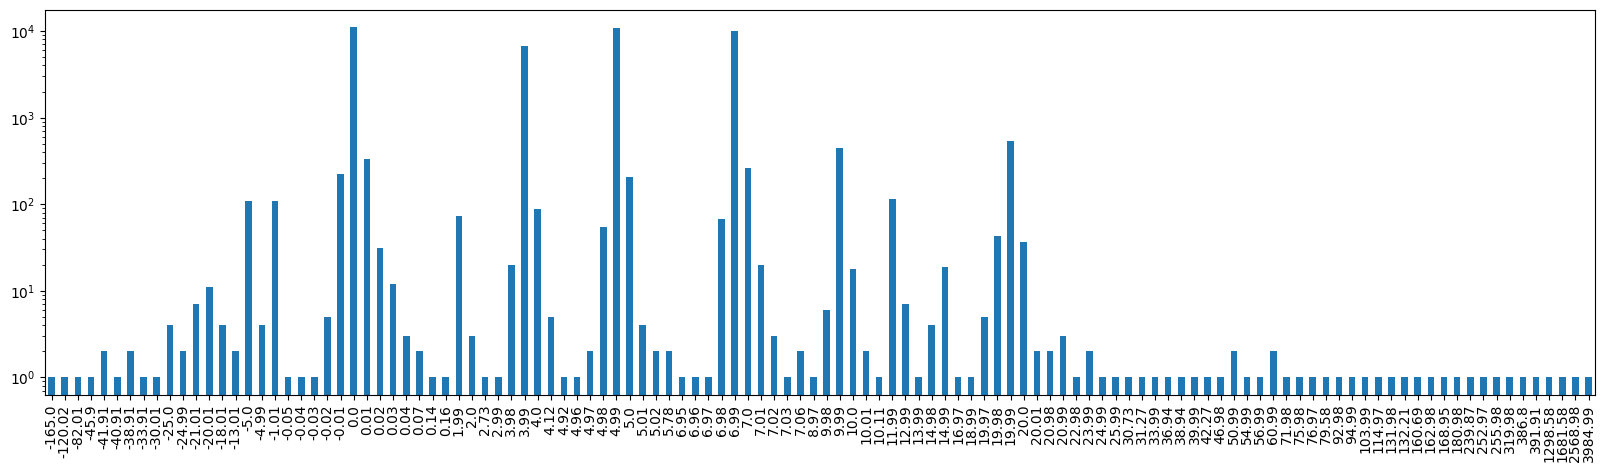

In [ ]:
orders['diff'].value_counts().sort_index().plot.bar(figsize=(20,5), logy=True);

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

- rounding by ±5 cents
- coupons
- vouchers / buying vouchers
- data corruption: missing orderlines
- refunds
- unpaid orders on invoice

### If there are differences that you can’t explain: what should you do with these orders?

{'count': 41701.0,
 'mean': 4.474808277978946,
 'std': 26.046477582495648,
 'min': -165.0,
 '25%': 0.0,
 '50%': 4.99,
 '75%': 6.99,
 'max': 3984.99,
 'left': -10.485,
 'right': 17.475}

Removing 716 outliers
New distribution:


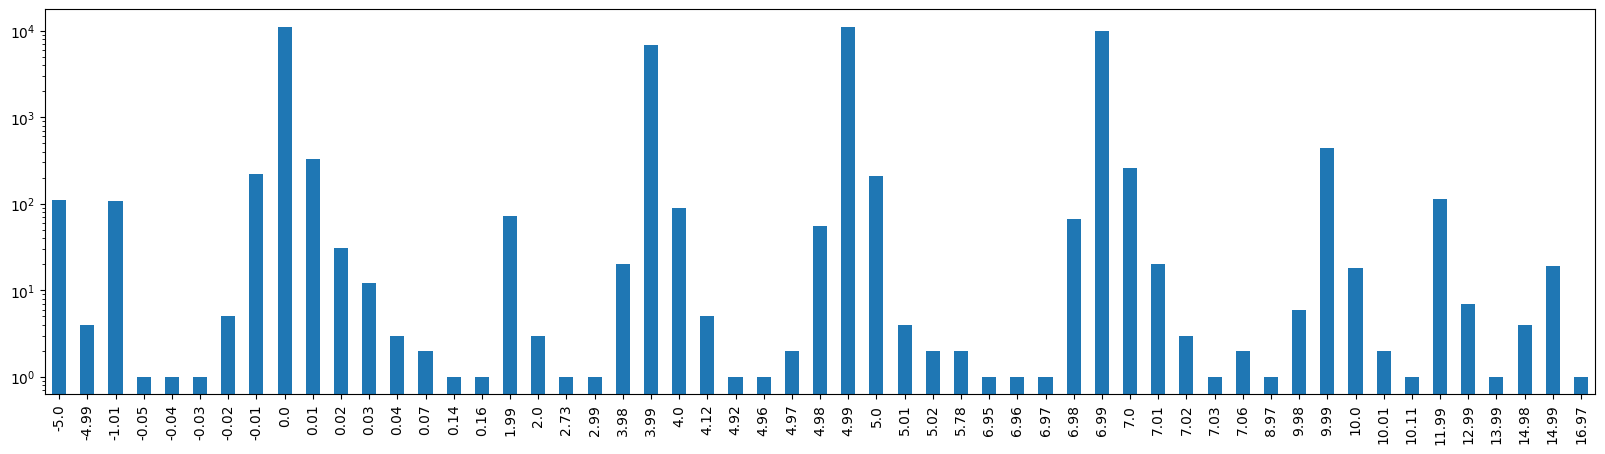

In [ ]:
# identify them as outliers and drop them
DEFAULT_IQR_FACTOR = 1.5

def range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR):
  '''
  Get series.describe() and add 'left'/'right' as confidence limits
  '''
  result = series.describe().to_dict()
  q3 = result['75%']
  q1 = result['25%']
  iqr = q3 - q1
  result['left'] = q1 - iqr_factor * iqr
  result['right'] = q3 + iqr_factor * iqr
  return result

display(range_of_confidence(orders['diff']))

def isin_range_of_confidence(series: pd.Series, iqr_factor = DEFAULT_IQR_FACTOR):
  roc = range_of_confidence(series, iqr_factor)
  return series.between(roc['left'], roc['right'])

print(f"Removing {(~isin_range_of_confidence(orders['diff'])).sum()} outliers")

orders = (
    orders
    [lambda x: isin_range_of_confidence(x['diff'])]
)

print('New distribution:')

orders['diff'].value_counts().sort_index().plot.bar(figsize=(20,5), logy=True);

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

In [ ]:
# your thoughts & code here

Do not forget to download your quality controlled DataFrames

In [ ]:
from google.colab import files

#orders_quality_controlled.to_csv("orders_qu.csv", index=False)
#files.download("orders_qu.csv")

#orderlines_quality_controlled.to_csv("orderlines_qu.csv", index=False)
#files.download("orderlines_qu.csv")